04/15/2019 09:38:25 - INFO - __main__ -   device: cuda n_gpu: 4, distributed training: False, 16-bits training: False
04/15/2019 09:38:25 - INFO - pytorch_pretrained_bert.tokenization -   loading vocabulary file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased-vocab.txt from cache at /home/belgundlibharat/.pytorch_pretrained_bert/bb773818882b0524dc53a1b31a2cc95bc489f000e7e19773ba07846011a6c711.535306b226c42cebebbc0dabc83b92ab11260e9919e21e2ab0beb301f267b4c7
04/15/2019 09:38:25 - INFO - pytorch_pretrained_bert.file_utils -   https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-multilingual-uncased.tar.gz not found in cache, downloading to /tmp/tmp2z_r4cs_
  2%|▏         | 11895808/623743758 [00:00<00:36, 16828721.55B/s]


AttributeError: 'NoneType' object has no attribute 'to'

<Figure size 432x288 with 0 Axes>

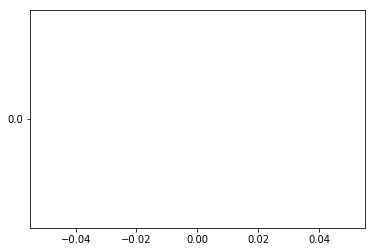

In [2]:
# -*- coding: utf-8 -*-
"""
Created on Tue Apr  9 15:52:34 2019

@author: Bharat
"""


#     Hugging face is taken as reference.
#     

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import unicodedata
import string
import re
import random
import time
import math
import os
import json
import xml.etree.ElementTree as ET
from __future__ import absolute_import, division, print_function
import easydict
import argparse
import csv
import logging
import os
import random
import sys
import re
import numpy as np
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler,
                              TensorDataset)
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange

from pytorch_pretrained_bert.file_utils import PYTORCH_PRETRAINED_BERT_CACHE
from pytorch_pretrained_bert.modeling import BertForSequenceClassification, BertConfig, WEIGHTS_NAME, CONFIG_NAME
from pytorch_pretrained_bert.tokenization import BertTokenizer
from pytorch_pretrained_bert.optimization import BertAdam, warmup_linear

logging.basicConfig(format = '%(asctime)s - %(levelname)s - %(name)s -   %(message)s',
                    datefmt = '%m/%d/%Y %H:%M:%S',
                    level = logging.INFO)
logger = logging.getLogger(__name__)


MODEL_SAVED_LOAD=False
plot_losses = []

class InputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self, guid, text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label
        
class xmlInputExample(object):
    """A single training/test example for simple sequence classification."""

    def __init__(self,text_a, text_b=None, label=None):
        """Constructs a InputExample.
        Args:
            guid: Unique id for the example.
            text_a: string. The untokenized text of the first sequence. For single
            sequence tasks, only this sequence must be specified.
            text_b: (Optional) string. The untokenized text of the second sequence.
            Only must be specified for sequence pair tasks.
            label: (Optional) string. The label of the example. This should be
            specified for train and dev examples, but not for test examples.
        """
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, input_mask, segment_ids, label_id):
        self.input_ids = input_ids
        self.input_mask = input_mask
        self.segment_ids = segment_ids
        self.label_id = label_id


class DataProcessor(object):
    """Base class for data converters for sequence classification data sets."""

    def get_train_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the train set."""
        raise NotImplementedError()

    def get_dev_examples(self, data_dir):
        """Gets a collection of `InputExample`s for the dev set."""
        raise NotImplementedError()

    def get_labels(self):
        """Gets the list of labels for this data set."""
        raise NotImplementedError()

    @classmethod
    def _read_tsv(cls, input_file, quotechar=None):
        """Reads a tab separated value file."""
        with open(input_file, "r") as f:
            reader = csv.reader(f, delimiter="\t", quotechar=quotechar)
            lines = []
            for line in reader:
                if sys.version_info[0] == 2:
                    line = list(unicode(cell, 'utf-8') for cell in line)
                lines.append(line)
            return lines


class MrpcProcessor(DataProcessor):
    """Processor for the MRPC data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        logger.info("LOOKING AT {}".format(os.path.join(data_dir, "train.tsv")))
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            text_b = line[4]
            label = line[0]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples


class MnliProcessor(DataProcessor):
    """Processor for the MultiNLI data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev_matched.tsv")),
            "dev_matched")

    def get_labels(self):
        """See base class."""
        return ["contradiction", "entailment", "neutral"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, line[0])
            text_a = line[8]
            text_b = line[9]
            label = line[-1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=text_b, label=label))
        return examples


class ColaProcessor(DataProcessor):
    """Processor for the CoLA data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            guid = "%s-%s" % (set_type, i)
            text_a = line[3]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples


class Amn5Processor(DataProcessor):
    """Processor for the AMN-5 data set AmazonFoodReview."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["1", "2","3","4","5"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            #print(text_a)
            label = line[1]
            #print(label)
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples
    

class BBC5Processor(DataProcessor):
    """Processor for the AMN-5 data set AmazonFoodReview."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")
    
    def get_train_xmlexamples(self, data_dir):
        """See base class."""
        return self._xmlcreate_examples(os.path.join(data_dir, "train.xml"))
    
    def get_dev_xmlexamples(self, data_dir):
        """See base class."""
        return self._xmlcreate_examples(os.path.join(data_dir, "dev.xml"))
    
    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "eval.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["positive", "neutral","negative"]
    
    def _xmlcreate_examples(self,path):
        tree = ET.parse(path)
        root = tree.getroot()
        texts=[]
        examples = []
        sentiment=[]
        for neighbor in root.iter('text'):
            texts.append(normalize_string(neighbor.text))
        for neighbor in root.iter('sentiment'):
            sentiment.append(neighbor.text)
        for (i,x) in enumerate(texts):
            examples.append(
                    xmlInputExample(text_a=texts[i], text_b=None, label=sentiment[i]))
        return examples
        

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            #print(text_a)
            label = line[1]
            #print(label)
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples


    


def normalize_string(s):
    #print(s)
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[?]", r"", s)
    s = re.sub(r"[.]", r"", s)
    s = re.sub(r"[!]", r"", s)
    s = re.sub(r"[^a-zA-Z.!?_.äöüß]+", r" ", s)
    return s 

class Sst2Processor(DataProcessor):
    """Processor for the SST-2 data set (GLUE version)."""

    def get_train_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "train.tsv")), "train")

    def get_dev_examples(self, data_dir):
        """See base class."""
        return self._create_examples(
            self._read_tsv(os.path.join(data_dir, "dev.tsv")), "dev")

    def get_labels(self):
        """See base class."""
        return ["0", "1"]

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines):
            if i == 0:
                continue
            guid = "%s-%s" % (set_type, i)
            text_a = line[0]
            label = line[1]
            examples.append(
                InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples


def convert_examples_to_features(examples, label_list, max_seq_length, tokenizer):
    """Loads a data file into a list of `InputBatch`s."""

    label_map = {label : i for i, label in enumerate(label_list)}

    features = []
    for (ex_index, example) in enumerate(examples):
        tokens_a = tokenizer.tokenize(example.text_a)

        tokens_b = None
        if example.text_b:
            tokens_b = tokenizer.tokenize(example.text_b)
            # Modifies `tokens_a` and `tokens_b` in place so that the total
            # length is less than the specified length.
            # Account for [CLS], [SEP], [SEP] with "- 3"
            _truncate_seq_pair(tokens_a, tokens_b, max_seq_length - 3)
        else:
            # Account for [CLS] and [SEP] with "- 2"
            if len(tokens_a) > max_seq_length - 2:
                tokens_a = tokens_a[:(max_seq_length - 2)]

        # The convention in BERT is:
        # (a) For sequence pairs:
        #  tokens:   [CLS] is this jack ##son ##ville ? [SEP] no it is not . [SEP]
        #  type_ids: 0   0  0    0    0     0       0 0    1  1  1  1   1 1
        # (b) For single sequences:
        #  tokens:   [CLS] the dog is hairy . [SEP]
        #  type_ids: 0   0   0   0  0     0 0
        #
        # Where "type_ids" are used to indicate whether this is the first
        # sequence or the second sequence. The embedding vectors for `type=0` and
        # `type=1` were learned during pre-training and are added to the wordpiece
        # embedding vector (and position vector). This is not *strictly* necessary
        # since the [SEP] token unambigiously separates the sequences, but it makes
        # it easier for the model to learn the concept of sequences.
        #
        # For classification tasks, the first vector (corresponding to [CLS]) is
        # used as as the "sentence vector". Note that this only makes sense because
        # the entire model is fine-tuned.
        tokens = ["[CLS]"] + tokens_a + ["[SEP]"]
        segment_ids = [0] * len(tokens)

        if tokens_b:
            tokens += tokens_b + ["[SEP]"]
            segment_ids += [1] * (len(tokens_b) + 1)

        input_ids = tokenizer.convert_tokens_to_ids(tokens)

        # The mask has 1 for real tokens and 0 for padding tokens. Only real
        # tokens are attended to.
        input_mask = [1] * len(input_ids)

        # Zero-pad up to the sequence length.
        padding = [0] * (max_seq_length - len(input_ids))
        input_ids += padding
        input_mask += padding
        segment_ids += padding

        assert len(input_ids) == max_seq_length
        assert len(input_mask) == max_seq_length
        assert len(segment_ids) == max_seq_length

        label_id = label_map[example.label]
        if ex_index < 5:
            logger.info("*** Example ***")
            #logger.info("guid: %s" % (example.guid))
            logger.info("tokens: %s" % " ".join(
                    [str(x) for x in tokens]))
            logger.info("input_ids: %s" % " ".join([str(x) for x in input_ids]))
            logger.info("input_mask: %s" % " ".join([str(x) for x in input_mask]))
            logger.info(
                    "segment_ids: %s" % " ".join([str(x) for x in segment_ids]))
            logger.info("label: %s (id = %d)" % (example.label, label_id))

        features.append(
                InputFeatures(input_ids=input_ids,
                              input_mask=input_mask,
                              segment_ids=segment_ids,
                              label_id=label_id))
    return features


def _truncate_seq_pair(tokens_a, tokens_b, max_length):
    """Truncates a sequence pair in place to the maximum length."""

    # This is a simple heuristic which will always truncate the longer sequence
    # one token at a time. This makes more sense than truncating an equal percent
    # of tokens from each, since if one sequence is very short then each token
    # that's truncated likely contains more information than a longer sequence.
    while True:
        total_length = len(tokens_a) + len(tokens_b)
        if total_length <= max_length:
            break
        if len(tokens_a) > len(tokens_b):
            tokens_a.pop()
        else:
            tokens_b.pop()

def accuracy(out, labels):
    outputs = np.argmax(out, axis=1)
    return np.sum(outputs == labels)


def show_plot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2) # put ticks at regular intervals
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

show_plot(plot_losses)

def main():
    args = easydict.EasyDict({
        "data_dir": '//home//belgundlibharat//SentimentAnalysis//MResult',
        "bert_model": "bert-base-multilingual-uncased",
        "task_name":"amn-5",
        "output_dir": '//home//belgundlibharat//SentimentAnalysis//MResult//output1',
        "cache_dir":"//home//belgundlibharat//SentimentAnalysis//MResult//output1",
        "max_seq_length":128,
        "do_train":True,
        "do_eval":False,
        "do_lower_case":True,
        "train_batch_size":8,
        "eval_batch_size":4,
        "learning_rate": 3e-5,
        "num_train_epochs":6.0,
        "warmup_proportion": 0.1,
        "no_cuda":False,
        "local_rank":-1,
        "seed": 42,
        "gradient_accumulation_steps":1,
        "fp16": False,
        "loss_scale":0
    })

    processors = {
        "cola": ColaProcessor,
        "mnli": MnliProcessor,
        "mrpc": MrpcProcessor,
        "sst-2": Sst2Processor,
        "amn-5": Amn5Processor,
        "bbc-5":BBC5Processor,
    }

    num_labels_task = {
        "cola": 2,
        "sst-2": 2,
        "mnli": 3,
        "mrpc": 2,
        "amn-5": 2,
        "bbc-5": 3,
    }

    if args.local_rank == -1 or args.no_cuda:
        device = torch.device("cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu")
        n_gpu = torch.cuda.device_count()
    else:
        torch.cuda.set_device(args.local_rank)
        device = torch.device("cuda", args.local_rank)
        n_gpu = 1
        # Initializes the distributed backend which will take care of sychronizing nodes/GPUs
        torch.distributed.init_process_group(backend='nccl')
    logger.info("device: {} n_gpu: {}, distributed training: {}, 16-bits training: {}".format(
        device, n_gpu, bool(args.local_rank != -1), args.fp16))

    if args.gradient_accumulation_steps < 1:
        raise ValueError("Invalid gradient_accumulation_steps parameter: {}, should be >= 1".format(
                            args.gradient_accumulation_steps))

    args.train_batch_size = args.train_batch_size // args.gradient_accumulation_steps

    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    if n_gpu > 0:
        torch.cuda.manual_seed_all(args.seed)

    if not args.do_train and not args.do_eval:
        raise ValueError("At least one of `do_train` or `do_eval` must be True.")

    if os.path.exists(args.output_dir) and os.listdir(args.output_dir) and args.do_train:
        raise ValueError("Output directory ({}) already exists and is not empty.".format(args.output_dir))
    if not os.path.exists(args.output_dir):
        os.makedirs(args.output_dir)

    task_name = args.task_name.lower()

    if task_name not in processors:
        raise ValueError("Task not found: %s" % (task_name))

    processor = processors[task_name]()
    num_labels = num_labels_task[task_name]
    label_list = processor.get_labels()

    tokenizer = BertTokenizer.from_pretrained(args.bert_model, do_lower_case=args.do_lower_case)

    train_examples = None
    num_train_optimization_steps = None
    if args.do_train:
        train_examples = processor.get_train_examples(args.data_dir)
        num_train_optimization_steps = int(
            len(train_examples) / args.train_batch_size / args.gradient_accumulation_steps) * args.num_train_epochs
        if args.local_rank != -1:
            num_train_optimization_steps = num_train_optimization_steps // torch.distributed.get_world_size()

    # Prepare model
    cache_dir = args.cache_dir if args.cache_dir else os.path.join(str(PYTORCH_PRETRAINED_BERT_CACHE), 'distributed_{}'.format(args.local_rank))
    model = BertForSequenceClassification.from_pretrained(args.bert_model,
              cache_dir=cache_dir,
              num_labels = num_labels)
    if args.fp16:
        model.half()
    model.to(device)
    if args.local_rank != -1:
        try:
            from apex.parallel import DistributedDataParallel as DDP
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

        model = DDP(model)
    elif n_gpu > 1:
        model = torch.nn.DataParallel(model)

    # Prepare optimizer
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'LayerNorm.bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
        ]
    if args.fp16:
        try:
            from apex.optimizers import FP16_Optimizer
            from apex.optimizers import FusedAdam
        except ImportError:
            raise ImportError("Please install apex from https://www.github.com/nvidia/apex to use distributed and fp16 training.")

        optimizer = FusedAdam(optimizer_grouped_parameters,
                              lr=args.learning_rate,
                              bias_correction=False,
                              max_grad_norm=1.0)
        if args.loss_scale == 0:
            optimizer = FP16_Optimizer(optimizer, dynamic_loss_scale=True)
        else:
            optimizer = FP16_Optimizer(optimizer, static_loss_scale=args.loss_scale)

    else:
        optimizer = BertAdam(optimizer_grouped_parameters,
                             lr=args.learning_rate,
                             warmup=args.warmup_proportion,
                             t_total=num_train_optimization_steps)

    global_step = 0
    nb_tr_steps = 0
    tr_loss = 0
    if args.do_train:
        train_features = convert_examples_to_features(
            train_examples, label_list, args.max_seq_length, tokenizer)
        logger.info("***** Running training *****")
        logger.info("  Num examples = %d", len(train_examples))
        logger.info("  Batch size = %d", args.train_batch_size)
        logger.info("  Num steps = %d", num_train_optimization_steps)
        all_input_ids = torch.tensor([f.input_ids for f in train_features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in train_features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in train_features], dtype=torch.long)
        all_label_ids = torch.tensor([f.label_id for f in train_features], dtype=torch.long)
        train_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
        print("printing train_data")
        print(len(train_data))
        if args.local_rank == -1:
            train_sampler = RandomSampler(train_data)
        else:
            train_sampler = DistributedSampler(train_data)
        print("printing train_sampler")
        print(len(train_sampler))
        train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=args.train_batch_size)
        print("Printing train_dataloader")
        print(len(train_dataloader))
        
        model.train()
        # Configuring training
        print_every = 10
        plot_loss_total = 0 # Reset every plot_every
        
        # Keep track of time elapsed and running averages
        start = time.time()
        print_loss_total = 0 # Reset every print_every
        for _ in trange(int(args.num_train_epochs), desc="Epoch"):
            tr_loss = 0
            nb_tr_examples, nb_tr_steps = 0, 0
            for step, batch in enumerate(tqdm(train_dataloader, desc="Iteration")):
                batch = tuple(t.to(device) for t in batch)
                input_ids, input_mask, segment_ids, label_ids = batch
                loss = model(input_ids, segment_ids, input_mask, label_ids)
                if n_gpu > 1:
                    loss = loss.mean() # mean() to average on multi-gpu.
                if args.gradient_accumulation_steps > 1:
                    loss = loss / args.gradient_accumulation_steps

                if args.fp16:
                    optimizer.backward(loss)
                else:
                    loss.backward()
                    
                plot_loss_total += loss
                    
                if step % plot_every == 0:
                    plot_loss_avg = plot_loss_total / plot_every
                    plot_losses.append(plot_loss_avg)
                    plot_loss_total = 0
                    
                tr_loss += loss.item()
                nb_tr_examples += input_ids.size(0)
                nb_tr_steps += 1
                if (step + 1) % args.gradient_accumulation_steps == 0:
                    if args.fp16:
                        # modify learning rate with special warm up BERT uses
                        # if args.fp16 is False, BertAdam is used that handles this automatically
                        lr_this_step = args.learning_rate * warmup_linear(global_step/num_train_optimization_steps, args.warmup_proportion)
                        for param_group in optimizer.param_groups:
                            param_group['lr'] = lr_this_step
                    optimizer.step()
                    optimizer.zero_grad()
                    global_step += 1

        # Save a trained model and the associated configuration
        model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self
        output_model_file = os.path.join(args.output_dir, WEIGHTS_NAME)
        torch.save(model_to_save.state_dict(), output_model_file)
        output_config_file = os.path.join(args.output_dir, CONFIG_NAME)
        with open(output_config_file, 'w') as f:
            f.write(model_to_save.config.to_json_string())

        # Load a trained model and config that you have fine-tuned
        config = BertConfig(output_config_file)
        model = BertForSequenceClassification(config, num_labels=num_labels)
        model.load_state_dict(torch.load(output_model_file))
    show_plot(plot_losses)
    if MODEL_SAVED_LOAD:
        model_to_save = model.module if hasattr(model, 'module') else model
        output_model_file = os.path.join(args.output_dir, WEIGHTS_NAME)
        output_config_file = os.path.join(args.output_dir, CONFIG_NAME)
        config = BertConfig(output_config_file)
        model = BertForSequenceClassification(config,num_labels=num_labels)
        model.load_state_dict(torch.load(output_model_file))
        
    model.to(device)

    if args.do_eval and (args.local_rank == -1 or torch.distributed.get_rank() == 0):
        eval_examples = processor.get_dev_examples(args.data_dir)
        eval_features = convert_examples_to_features(
            eval_examples, label_list, args.max_seq_length, tokenizer)
        logger.info("***** Running evaluation *****")
        logger.info("  Num examples = %d", len(eval_examples))
        logger.info("  Batch size = %d", args.eval_batch_size)
        all_input_ids = torch.tensor([f.input_ids for f in eval_features], dtype=torch.long)
        all_input_mask = torch.tensor([f.input_mask for f in eval_features], dtype=torch.long)
        all_segment_ids = torch.tensor([f.segment_ids for f in eval_features], dtype=torch.long)
        all_label_ids = torch.tensor([f.label_id for f in eval_features], dtype=torch.long)
        eval_data = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
        # Run prediction for full data
        eval_sampler = SequentialSampler(eval_data)
        eval_dataloader = DataLoader(eval_data, sampler=eval_sampler, batch_size=args.eval_batch_size)

        model.eval()
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0

        for input_ids, input_mask, segment_ids, label_ids in tqdm(eval_dataloader, desc="Evaluating"):
            input_ids = input_ids.to(device)
            input_mask = input_mask.to(device)
            segment_ids = segment_ids.to(device)
            label_ids = label_ids.to(device)
            print("printing loss before for loop")
            with torch.no_grad():
                tmp_eval_loss = model(input_ids, segment_ids, input_mask, label_ids)
                print("printing loss")
                print(tmp_eval_loss)
                logits = model(input_ids, segment_ids, input_mask)

            logits = logits.detach().cpu().numpy()
            label_ids = label_ids.to('cpu').numpy()
            tmp_eval_accuracy = accuracy(logits, label_ids)
            print("mean loss")
            print(tmp_eval_loss.mean().item())
            eval_loss += tmp_eval_loss.mean().item()
            eval_accuracy += tmp_eval_accuracy

            nb_eval_examples += input_ids.size(0)
            nb_eval_steps += 1

        eval_loss = eval_loss / nb_eval_steps
        eval_accuracy = eval_accuracy / nb_eval_examples
        loss = tr_loss/nb_tr_steps if args.do_train else None
        result = {'eval_loss': eval_loss,
                  'eval_accuracy': eval_accuracy,
                  'global_step': global_step,
                  'loss': loss}

        output_eval_file = os.path.join(args.output_dir, "eval_results.txt")
        with open(output_eval_file, "w") as writer:
            logger.info("***** Eval results *****")
            for key in sorted(result.keys()):
                logger.info("  %s = %s", key, str(result[key]))
                writer.write("%s = %s\n" % (key, str(result[key])))

if __name__ == "__main__":
    main()